In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler

# Processing Data

In [ ]:
def processing_data(file_path):

  if not isinstance(file_path, str):

    raise ValueError("Not a string.")

  # Reading Excel File
  df_heart_dis = pd.read_excel(file_path)

  # Removing Duplicate Rows
  df_heart_dis = df_heart_dis.drop_duplicates()

  # Removing Empty Rows
  df_heart_dis = df_heart_dis.dropna()

  # Removing Uncessary columns
  columns_to_drop = ["height", "weight", "age", "bp_category_encoded", "id"]

  df_heart_dis.drop(columns = columns_to_drop, inplace = True)

  # Converting Male(2) = 0 & Female(1) = 1
  df_heart_dis["gender"] = df_heart_dis["gender"].apply(lambda x: 0 if x == 2 else 1)

  # One Hot-Encoding
  labels = {
    1: "normal",
    2: "above_normal",
    3: "well_above_normal"
  }

  df_heart_dis["cholesterol"] = df_heart_dis["cholesterol"].map(labels)
  df_heart_dis["gluc"] = df_heart_dis["gluc"].map(labels)

  df_heart_dis = pd.get_dummies(df_heart_dis, columns = ["bp_category", "cholesterol", "gluc"], prefix = ["bp_category", "chol", "gluc"])

  dummy_cols = [col for col in df_heart_dis.columns if col.startswith(("bp_category", "chol", "gluc"))]

  df_heart_dis[dummy_cols] = df_heart_dis[dummy_cols].astype(int) # Converting True = 1 & False = 0

  # Normalising Numerical Data
  num_cols = df_heart_dis.select_dtypes(include = ["float64", "int64"]).columns

  scaler = MinMaxScaler()

  df_heart_dis[num_cols] = scaler.fit_transform(df_heart_dis[num_cols])

  return df_heart_dis

In [ ]:
df_heart_dis = processing_data("cardiovascular_dataset.xlsx")

print("Class Distribution:\n", df_heart_dis["cardio"].value_counts(),"\n")
print(df_heart_dis.head(5))

Class Distribution:
 cardio
0.0    34533
1.0    33672
Name: count, dtype: int64 

   gender     ap_hi     ap_lo  smoke  alco  active  cardio  age_years  \
0     0.0  0.222222  0.333333    0.0   0.0     1.0     0.0   0.600000   
1     1.0  0.555556  0.500000    0.0   0.0     1.0     1.0   0.742857   
2     1.0  0.444444  0.166667    0.0   0.0     0.0     1.0   0.628571   
3     0.0  0.666667  0.666667    0.0   0.0     1.0     1.0   0.542857   
4     1.0  0.111111  0.000000    0.0   0.0     0.0     0.0   0.514286   

        bmi  bp_category_Elevated  bp_category_Hypertension Stage 1  \
0  0.062655                   0.0                               1.0   
1  0.106560                   0.0                               0.0   
2  0.067874                   0.0                               1.0   
3  0.085498                   0.0                               0.0   
4  0.066192                   0.0                               0.0   

   bp_category_Hypertension Stage 2  bp_category_Nor

# Training, Validation & Testing

---



In [ ]:
X_data = df_heart_dis.drop(columns = "cardio")
y_target = df_heart_dis["cardio"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_data,
    y_target,
    test_size = 0.2, # 20% for testing
    random_state = 42,
    stratify = y_target
    )

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train,
    y_train,
    test_size = 0.125,       #10% of training for validation
    random_state = 42,
    stratify = y_train
)

x_train = torch.from_numpy(X_train.values).float()
x_val = torch.from_numpy(X_val.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1) # shape(kx1)

y_val = torch.from_numpy(y_val.values).float()
y_val = y_val.reshape(-1, 1) # shape(kx1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1) # shape(kx1)


print("Number of Features: {}".format(x_train.shape[1]))
print(x_train[0])
print(y_train[0])

print("\nNumber of Examples:{}".format(len(df_heart_dis)))
print("\nTraining Examples:{}".format(len(x_train)))
print("Validation Examples:{}".format(len(x_val)))
print("Testing Examples:{}".format(len(x_test)))

Number of Features: 18
tensor([1.0000, 0.3333, 0.3333, 0.0000, 0.0000, 1.0000, 0.6286, 0.0626, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([0.])

Number of Examples:68205

Training Examples:47743
Validation Examples:6821
Testing Examples:13641


In [ ]:
# Creating DataLoaders for mini batch SGD
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

# Classification Model

In [ ]:
class NeuralNet(torch.nn.Module):

    def __init__(self, num_inputs):
        super(NeuralNet, self).__init__()

        self.num_inputs = num_inputs

        self.Linear1 = torch.nn.Linear(num_inputs, 18)
        self.relu = torch.nn.ReLU()

        self.Linear2 = torch.nn.Linear(18, 36)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.relu2 = torch.nn.ReLU()

        self.Linear3 = torch.nn.Linear(36, 64)
        self.relu3 = torch.nn.ReLU()

        self.out_layer = torch.nn.Linear(64, 1)

        # Initialising Weight Matrix for each layer
        torch.nn.init.kaiming_normal_(self.Linear1.weight, nonlinearity = "relu")
        torch.nn.init.kaiming_normal_(self.Linear2.weight, nonlinearity = "relu")
        torch.nn.init.kaiming_normal_(self.Linear3.weight, nonlinearity = "relu")
        torch.nn.init.xavier_uniform_(self.out_layer.weight)

        # Initialising Bias Vector for each layer
        torch.nn.init.zeros_(self.Linear1.bias)
        torch.nn.init.zeros_(self.Linear2.bias)
        torch.nn.init.zeros_(self.Linear3.bias)
        torch.nn.init.zeros_(self.out_layer.bias)


    def forward(self, x):

        x = self.Linear1(x)
        x = self.relu(x)

        x = self.Linear2(x)
        x = self.dropout2(x)
        x = self.relu2(x)

        x = self.Linear3(x)
        x = self.relu3(x)

        out = self.out_layer(x)

        return out

# Training Model

In [ ]:
def compute_metrics(true_labels, pred_labels):

  tp, fp = 0, 0
  tn, fn = 0, 0

  for true, pred in zip(true_labels, pred_labels):

    if true == 1 and pred == 1:

      tp += 1

    elif true == 0 and pred == 0:

      tn += 1

    elif true == 0 and pred == 1:

      fp += 1

    else:

      fn += 1

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  return accuracy, precision, recall, f1_score

In [ ]:
num_features = x_train.shape[1]
model = NeuralNet(num_features)

loss = torch.nn.BCEWithLogitsLoss()
lr = 0.01 # best lr = 0.01
optmizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
def train(model, train_loader, val_loader, optmizer, loss, num_epochs):

  train_losses = []
  train_accs = []

  val_losses = []
  val_accs = []

  for epoch in range(num_epochs):

    model.train()

    loss_per_epoch = 0
    acc_per_epoch = 0

    print(f'\nEpoch {epoch + 1}/{num_epochs}.')

    for batch_x, batch_y in train_loader:

      train_logits = model(batch_x)

      train_loss = loss(train_logits, batch_y)

      optmizer.zero_grad()

      train_loss.backward()

      optmizer.step()

      train_preds = torch.sigmoid(train_logits) > 0.5

      train_acc, _, _, _ = compute_metrics(batch_y, train_preds)

      loss_per_epoch += train_loss.item()
      acc_per_epoch += train_acc

    avg_train_loss = loss_per_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_train_acc = acc_per_epoch / len(train_loader)
    train_accs.append(avg_train_acc * 100)

    print("Train Loss:{}, Acc:{}".format(avg_train_loss, avg_train_acc * 100))

    #------Evaluating Model on Validation Dataset---------
    model.eval()

    loss_per_epoch = 0
    acc_per_epoch = 0

    with torch.no_grad():

      for batch_x, batch_y in val_loader:

        val_logits = model(batch_x)
        val_loss = loss(val_logits, batch_y)

        val_preds = torch.sigmoid(val_logits) > 0.5

        val_acc, _, _, _ = compute_metrics(batch_y, val_preds)

        loss_per_epoch += val_loss.item()
        acc_per_epoch += val_acc

      avg_val_loss = loss_per_epoch / len(val_loader)
      val_losses.append(avg_val_loss)

      avg_val_acc = acc_per_epoch / len(val_loader)
      val_accs.append(avg_val_acc * 100)

      print("Val Loss:{}, Acc:{}".format(avg_val_loss, avg_val_acc * 100))


  #------Plotting Loss and Accuracy Values---------
  plt.figure(figsize = (12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label = "Training Loss")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(val_losses, label = "Validation Loss")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.tight_layout()
  plt.show()

  plt.plot(train_accs, label = "Training accuracy")
  plt.plot(val_accs, label = "Validation accuracy")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy(%)")

  plt.show()


Epoch 1/20.
Train Loss:0.6459034443620703, Acc:63.196861757329415
Val Loss:0.594645228341361, Acc:68.9339953271028

Epoch 2/20.
Train Loss:0.5899493257257957, Acc:69.79245492086828
Val Loss:0.5739528549330257, Acc:70.73598130841121

Epoch 3/20.
Train Loss:0.5773294770206268, Acc:70.87119205655972
Val Loss:0.5709631195135205, Acc:71.10689252336448

Epoch 4/20.
Train Loss:0.5698658835552333, Acc:71.27928251751275
Val Loss:0.5653172762037437, Acc:71.51285046728971

Epoch 5/20.
Train Loss:0.5665337427371948, Acc:71.64169927786905
Val Loss:0.5644934595188248, Acc:71.59462616822431

Epoch 6/20.
Train Loss:0.5636292453705466, Acc:71.99823791403614
Val Loss:0.5606273508796068, Acc:71.86039719626169

Epoch 7/20.
Train Loss:0.5598396435779477, Acc:72.140934446078
Val Loss:0.5618833928743255, Acc:72.19918224299066

Epoch 8/20.
Train Loss:0.5595538549265018, Acc:72.22863335639539
Val Loss:0.5599979808397382, Acc:72.05607476635514

Epoch 9/20.
Train Loss:0.5565380567919473, Acc:72.41909809305544
V

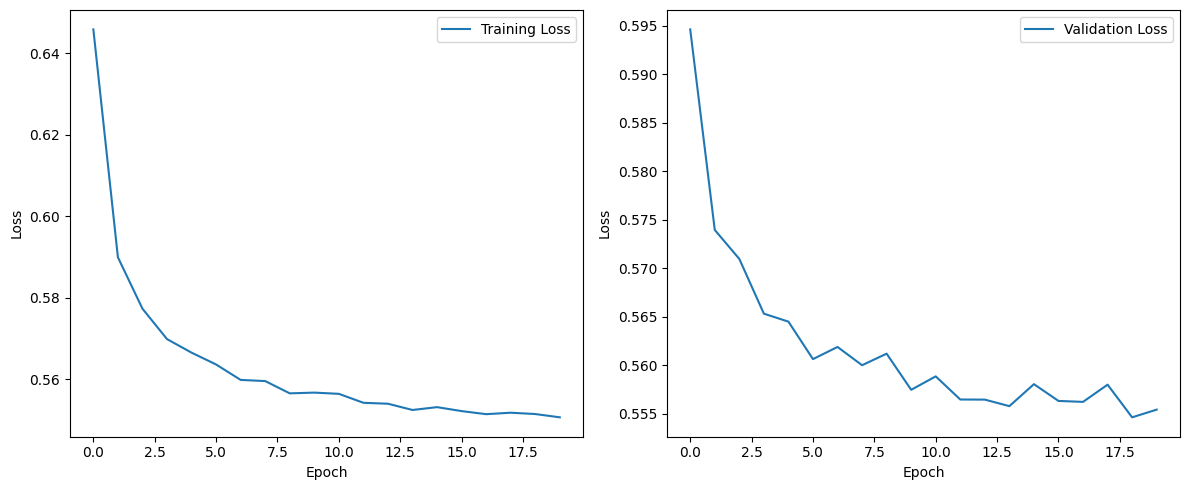

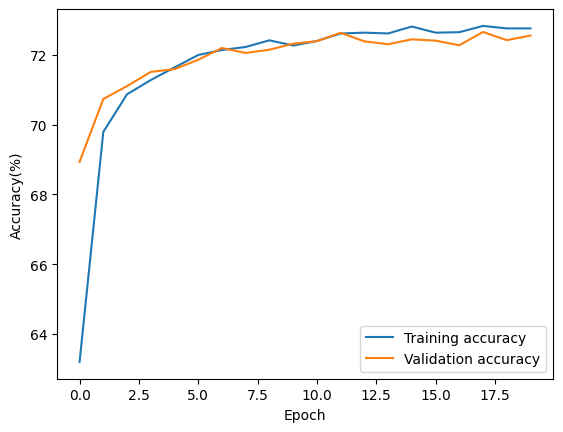

In [ ]:
train(model, train_loader, val_loader, optmizer, loss, num_epochs = 20)

# Evaluating Model

In [ ]:
def eval (model, x_test, y_test, loss):

  model.eval()

  with torch.no_grad():

    logits = model(x_test)
    l = loss(logits, y_test)

    predictions = torch.sigmoid(logits) > 0.5

    accuracy, precision, recall, f1_score = compute_metrics(y_test, predictions)

    print("Test Loss:{}\n".format(l.item()))
    print("Accuracy:{}".format(accuracy * 100))
    print("Precision:{}".format(precision))
    print("Recall:{}".format(recall))
    print("F1-Score:{}".format(f1_score))

In [ ]:
eval(model, x_test, y_test, loss)

Test Loss:0.547069251537323

Accuracy:73.11780661241845
Precision:0.7565668395516145
Recall:0.6715176715176715
F1-Score:0.7115097159940208


# Saving Classifier

In [ ]:
#import joblib

#joblib.dump(model, "neural_net_model.joblib")